## Quora Insincere questions classification

## Group Information:


*   **Aniket Bhatnagar (ab8700)**
*   **Dhruv Goyal (dg3278)**
*   **Yudhishthir Deshpande (yd1568)**




In [0]:
# Setup the directory to be in sync with notebook
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
!pip uninstall keras

Uninstalling Keras-2.2.5:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.2.5.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.2.5


In [0]:
!pip install keras==2.1.4

     |████████████████████████████████| 327kB 4.8MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.4 which is incompatible.


### **Introduction**
Quora is generally used for the purpose of knowledge sharing, where people across continents can put forth any questions that they have, and experts/ non-experts in that domain can revert back with an answer.

However, some questions intend to make a statement rather than looking for helpful answers, or are completely absurd and have no factual relevance. Quora marks such questions as Insincere, and in past hosted a kaggle competition to identify such questions. [1]

These questions can become a threat to the concept of a safe internet as some of these questions can imply negative opinion or promote hatred towards certain sections of society.

Furthermore, quora is extensively used by school and college students to seek answers pertaining to their school/ college curriculum and career development, and thus, the presence of such questions can be detrimental to the society at large.

In this project, we aim to develop a machine learning classifier to categorize insincere questions from the dataset hosted by Quora on kaggle.


### **Problem definition**
In this project, we aim to explore different machine learning classifiers and find the best classifier to categorize insincere questions from the dataset hosted by Quora on kaggle.

The input provided to solve the problem consists of list of questions, which we refer to hereafter as `full_text_data`, where `full_text_data[i]` represents a question in the dataset and can consist of arbitrary number of words.

For the present problem, we consider all the insincere questions to have label 1, while  all the sincere questions to have a label of 0. Thus, we consider all **sincere questions** to represent the **negative class**, while all **insincere questions** to represent the **positive  class**.


### **Experimental Evaluation**
#### **1. Data-set description**:
Quora's insincere question classification dataset consisted a total of **1,306,122** questions. While, the number of questions marked as insincere accounted for only **80,810** questions.

Thus only **6.19**% of the questions in the entire corpus are marked as Insincere. Hence, the dataset is highly skewed as the number of sincere questions far outnumber the number of insincere questions.

Furthermore, we analyzed relation between no of unique words in the dataset and the fraction of their occurence across each document (or document frequency). Noting down our observations:

statistic checked | value
--- | --- 
Total no of unique words in the dataset | 195,000
Words that appear in >= 0.1% documents | 1260
Words that appear in >= 0.01% documents | 7660
Words that appear  in >= 0.001% documents | 28583

Above observations are helpful when deciding the threshold for the no of words to be kept inside the vocabulary, as words which occur with rarer document  frequency  than 0.001%, most likely will not contribute much to the training of ML classifier.

Lastly, to check variation in the length of different questions present in the dataset, we sorted the questions wrt no of words contained in them, and report the no of words contained in question at different percentile value of the sorted list.

statistic checked | value
--- | --- 
No of words in question with length at 50th percentile | 11
No of words in question with length at 80th percentile | 17
No of words in question with length at 90th percentile | 22
No of words in question with length at 99th percentile | 39

After that, we repeated similar analysis for only the positive class (insincere questions class) samples.

statistic checked | value
--- | --- 
No of words in question with length at 50th percentile | 15
No of words in question with length at 80th percentile | 25
No of words in question with length at 90th percentile | 31
No of words in question with length at 99th percentile | 44

Above observations are helpful when deciding sequence length for traininig CNN on the above dataseet. Explained in later section.

#### **2. Methodology**
##### **2.1 Train-test split**
We first load the data and then split it into two sets, train and test sets. Since, the data is highly skewed, the sklearn’s train_test_split package will ensure that the distribution of labels of either category is similar across both the splits. We split the given dataset basis a 70-30 split where 70% samples would be used for  traininig, and remaining 30% for evaluating the model.

In [0]:
import os
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle, compute_class_weight

# Constants and file names
DATA_DIR = '/content/drive/My Drive/iml_project/quora_insincere_data'
DATA_FILE = os.path.join(DATA_DIR, 'train.csv')

# Load data
data = pd.read_csv(DATA_FILE, sep=',')
data_text = data['question_text']
data_labels = data['target']
del data

# Do train test split
train_texts, test_texts, y_train, y_test = train_test_split(
    data_text, data_labels, random_state=3, test_size=0.3, shuffle=True
)

# Convert train_text and test_text to lists
train_texts = train_texts.tolist()
test_texts = test_texts.tolist()

print  ("No of samples in train dataset", len(train_texts))
print  ("No of samples in test dataset", len(test_texts))


No of samples in train dataset 914285
No of samples in test dataset 391837


##### **2.2 Feature Extraction**
For the experiments where we utiliize conventional ML classifiers, we plan to extract **tf-idf (Term frequency-inverse document frequency)** scores for only those words in the vocabulary which occur in greater than or equal to **0.001%** documents. We assume that words which occur rarer than that will not contribute much to the training of ML classifier.

While, we plan to use **Word vector embeddings** for training **convolutional neural net** on the problem. We plan to compare both the results when training a model with **randomly iniitialized word vector embeddings**, and when initiializing these word vector embeddings from weights made available by Google (by training for word vectors on their **Google News corpus** dataset).  

We show data to feature conversion using word vector embeddings when we present the CNN model training code.

In [0]:
# Define feature extractor
vectorizer = TfidfVectorizer(lowercase=True, min_df=0.00001)  # Ignore words where document freq is lt 1% or gt 70%.

# Train vectorizer on the text data
vectorizer.fit(train_texts)
X_train = vectorizer.transform(train_texts)
X_test = vectorizer.transform(test_texts)

print ('Shape of training features matrix', X_train.shape)
print ('Shape of test features matrix', X_test.shape)

Shape of training features matrix (914285, 28592)
Shape of test features matrix (391837, 28592)


##### **2.3 Performance metrics**
Since the dataset's positive class, i.e. Insincere questions category is **greatly outnumbered** by the negative class (sincere category) samples. Hence, we can not use accuracy as a performance metric. This is because, if every sample in the dataset is marked sincere, then also the accuracy of the model will be **94%** as the insincere class datapoints in themselves only have a representation of roughly **6%**.

For the given problem we use **f1_score** to measure the performance of our classifier, where f1_score is a combinatiion of **precision**  and **recall**, where each  of  these is defined as:

    precision  = (TP/TP+FP)
    recall = TP/(TP+FN)
    f1_score = ((2*precision*recall) / (precision+recall))

##### **2.4 Algorithms Used**
**2.4.1 Logistic regression with ridge regularization**
In this section, we train and evaluate logistic regression classifier (with ridge regularization) on TfIdf feature representation of the data.
For  hyper-parameter  selection, we grid search through  multiple values of C, and present plot of train and validation f1-scores for different values of C.  

In [0]:
def plot_train_val_scores(train_scores, val_scores, param_values, classifier_type, param_name):
    # Plot train val scores
    from matplotlib import  pyplot as plt

    plt.plot(param_values, train_scores, color='b', label='train f1')
    plt.plot(param_values, val_scores, color='r', label='val f1')
    plt.title('Performance variation for {} with respect to parameter {}'.format(
        classifier_type, param_name
    ))
    plt.ylabel('f1 measure')
    plt.xlabel(param_name + ' param value')
    plt.legend(loc='lower right')
    plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


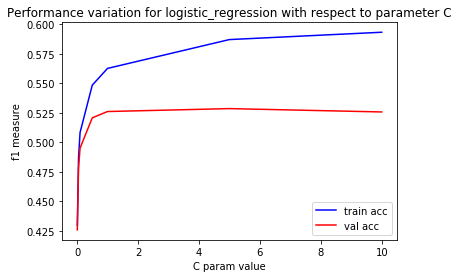

Performance metrics for logistic regressiion  with ridge regression
Precision 37.42
Recall 86.12
f1 score 52.17


In [0]:
# Define logistic regression object with ridge
lr = LogisticRegression(penalty='l2', class_weight='balanced', random_state=5)

# Define GridSearch object
param_grid = {
    'C': [1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10],
}
lr_gs = GridSearchCV(lr, param_grid=param_grid, n_jobs=-1, scoring='f1',
                     return_train_score=True)

# Fit the grid search object and print cv results
lr_gs.fit(X_train, y_train)
avg_cv_train_scores = lr_gs.cv_results_['mean_train_score']
avg_cv_test_scores = lr_gs.cv_results_['mean_test_score']

plot_train_val_scores(avg_cv_train_scores, avg_cv_test_scores, param_grid['C'],
                      classifier_type='logistic_regression', param_name='C')

# Predict on test set and find precision, recall and f1
y_preds = lr_gs.predict(X_test)
print ("Performance metrics for logistic regressiion  with ridge regression")
precision = precision_score(y_test, y_preds) * 100
recall = recall_score(y_test, y_preds) * 100
f1_score = (2 * precision * recall) / (precision + recall)

print ('Precision %.2f' % precision)
print ('Recall %.2f' % recall)
print ('f1 score %.2f' % f1_score)

**2.4.2 Logistic regression with lasso regularization**
In this section, we train and evaluate logistic regression classifier (with lasso regularization) on TfIdf feature representation of the data.
Simiilar to ridge regression, for hyper-parameter selection, we grid search through  multiple values of C, and present plot of train and validation f1-scores for different values of C.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


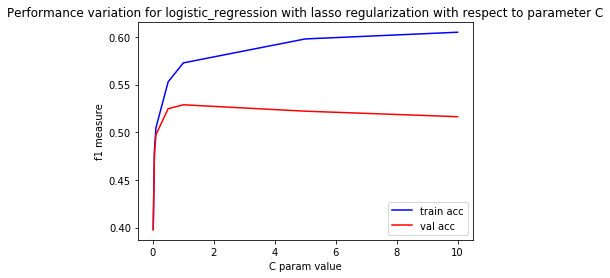

Performance metrics for logistic regressiion  with lasso regression
Precision 0.37
Recall 0.87
f1 score 0.52


In [0]:
# Define logistic regression object with lasso regularization
lr = LogisticRegression(penalty='l1', class_weight='balanced', random_state=5)

# Define GridSearch object
param_grid = {
    'C': [1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 10],
}
lr_gs = GridSearchCV(lr, param_grid=param_grid, n_jobs=-1, scoring='f1',
                     return_train_score=True)

# Fit the grid search object and print cv results
lr_gs.fit(X_train, y_train)
avg_cv_train_scores = lr_gs.cv_results_['mean_train_score']
avg_cv_test_scores = lr_gs.cv_results_['mean_test_score']

plot_train_val_scores(avg_cv_train_scores, avg_cv_test_scores, param_grid['C'],
                      classifier_type='logistic_regression with lasso regularization',
                      param_name='C')

# Predict on test set and find precision, recall and f1
y_preds = lr_gs.predict(X_test)
print ("Performance metrics for logistic regressiion  with lasso regression")
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1_score = (2 * precision * recall) / (precision + recall)

print ('Precision %.2f' % precision)
print ('Recall %.2f' % recall)
print ('f1 score %.2f' % f1_score)

**2.4.3 Decision Tree**  
In this section, we train and evaluate decision tree classifier on TfIdf feature representation of the data.
For hyper-parameter selection, we grid search through  multiple values of max-depth, and present plot of train and validation f1-scores for different values of maxc-depth.

In [0]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [20,30,40,60,85,90,100]
}

dtree = DecisionTreeClassifier()

grid = GridSearchCV(dtree, param_grid=param_grid, n_jobs=-1, scoring='f1',
                    return_train_score=True,)
grid.fit(X_train, y_train)

y_hat = grid.predict(X_test)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Precision 0.56
Recall 0.39
f1 score 0.45


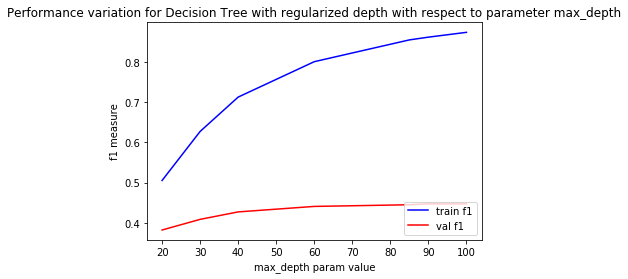

In [0]:
def printScores(yhat, ytest):
    precision = precision_score(ytest, yhat)
    recall = recall_score(ytest, yhat)
    f1 = 2*precision*recall/(precision+recall)
    print("Precision: %.2f" % precision*100)
    print("Recall: %.2f" % recall*100)
    print("F1 score: %.2f" % f1*100)

# print (y_hat.shape)
# printScores(y_hat, y_test)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
f1_score = (2 * precision * recall) / (precision + recall)

print ('Precision %.2f' % precision)
print ('Recall %.2f' % recall)
print ('f1 score %.2f' % f1_score)

avg_cv_train_scores = grid.cv_results_['mean_train_score']
avg_cv_test_scores = grid.cv_results_['mean_test_score']

plot_train_val_scores(avg_cv_train_scores, avg_cv_test_scores, param_grid['max_depth'],
                      classifier_type='Decision Tree with regularized depth',
                      param_name='max_depth')

**2.4.4 Random Forest**  
In this section, we train and evaluate Random Forest classifier on TfIdf feature representation of the data.
For hyper-parameter selection, we grid search through  multiple values of n_estimators, and present plot of train and validation f1-scores for different values of n_estimators. According to the previous graph for a decision tree we see that the f1 score on validation does not have a significant increase after a max_depth of 60. Thus we train our data on a random forest of trees with max_depth of 60 

In [0]:
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier(max_depth=60, random_state=42)

param_grid = {
    'n_estimators': [5, 10, 15, 20, 25]
}

grid_rf = GridSearchCV(rforest, param_grid=param_grid, n_jobs=-1, scoring='f1',
                       return_train_score=True)

grid_rf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=60,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={

Precision 0.73
Recall 0.06
f1 score 0.11


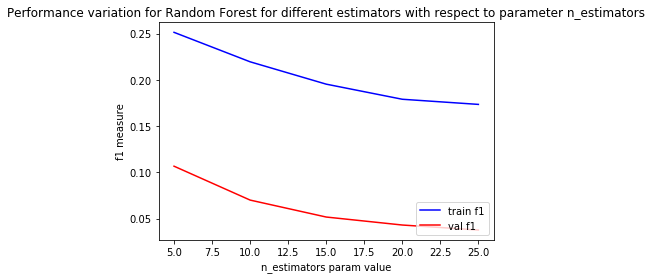

In [0]:
y_hat = grid_rf.predict(X_test)

precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
f1_score = (2 * precision * recall) / (precision + recall)

print ('Precision %.2f' % precision)
print ('Recall %.2f' % recall)
print ('f1 score %.2f' % f1_score)

avg_cv_train_scores = grid_rf.cv_results_['mean_train_score']
avg_cv_test_scores = grid_rf.cv_results_['mean_test_score']

plot_train_val_scores(avg_cv_train_scores, avg_cv_test_scores, param_grid['n_estimators'],
                      classifier_type='Random Forest for different estimators',
                      param_name='n_estimators')

**2.4.4 Single layer neural network**  
In this section, we train and evaluate single layer neural network classifier on TfIdf feature representation of the data.

We only have one single hidden layer in the network, which accepts tf-idf features as input, and pushes its activations to the output layer, which is a single neuron with sigmoid activation. While, the hidden layer contains 2048 neurons, and each neuron has Relu activation. 

The network is trained using mini-batch gradient descent with batch size of 128, and adam optimizer. 

In [0]:
# Keras specific imports
from keras import Input
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.engine import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling2D, merge, Flatten, Embedding, Reshape, Conv2D
from keras.optimizers import SGD
import keras
print (keras.__version__)

Using TensorFlow backend.


2.1.4


In [0]:
# Building keras specific precision, recall and f1 score methods
def recall_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.clip(y_true, 0, 1))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_metric(y_true, y_pred):
    prec = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    f1_score = (2 * prec * recall) / (prec + recall + K.epsilon())
    return f1_score

In [0]:
from numpy import loadtxt

model = Sequential()
model.add(Dense(2048, input_dim=28592, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=1e-2, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[precision_metric, recall_metric, f1_metric])

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, random_state=3, test_size=0.2, shuffle=True)

DNN_BEST_MODEL = 'single_layer_one.hdf5'
MODEl_FILE_PATH =  os.path.join(DATA_DIR, DNN_BEST_MODEL)
check_ptr = ModelCheckpoint(save_best_only=True, filepath=MODEl_FILE_PATH)
early_stopper = EarlyStopping(monitor='val_loss', patience=3)

# Compute class weights
class_weight = compute_class_weight('balanced', np.unique(y_train), y_train)

# Fit the model
model.fit(X_train_val, y_train_val, batch_size=128,
          epochs=20, class_weight=class_weight,
          validation_data=(X_val,y_val), callbacks=[check_ptr, early_stopper])


Train on 731428 samples, validate on 182857 samples
Epoch 1/20
731428/731428 [==============================] - 371s 507us/step - loss: 0.1978 - precision_metric: 0.1023 - recall_metric: 0.0211 - f1_metric: 0.0333 - val_loss: 0.1601 - val_precision_metric: 0.5191 - val_recall_metric: 0.1219 - val_f1_metric: 0.1880
Epoch 2/20
731428/731428 [==============================] - 366s 501us/step - loss: 0.1451 - precision_metric: 0.6172 - recall_metric: 0.2413 - f1_metric: 0.3274 - val_loss: 0.1392 - val_precision_metric: 0.6356 - val_recall_metric: 0.3612 - val_f1_metric: 0.4417
Epoch 3/20
731428/731428 [==============================] - 365s 499us/step - loss: 0.1313 - precision_metric: 0.6605 - recall_metric: 0.3434 - f1_metric: 0.4297 - val_loss: 0.1301 - val_precision_metric: 0.6653 - val_recall_metric: 0.3706 - val_f1_metric: 0.4558
Epoch 4/20
731428/731428 [==============================] - 366s 500us/step - loss: 0.1245 - precision_metric: 0.6744 - recall_metric: 0.3960 - f1_metric: 0

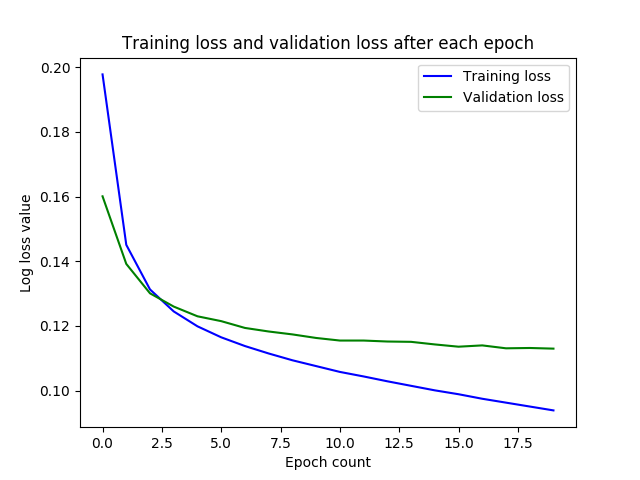

In [0]:
# DNN convergence plot
from IPython.display import Image
dnn_plot = os.path.join(DATA_DIR, 'dnn_convergence_plot.png')
Image(dnn_plot)

In [0]:
# Take predictions on test set
from keras.models import load_model
DNN_BEST_MODEL = 'single_layer_one.hdf5'
DNN_FILE_PATH = os.path.join(DATA_DIR, DNN_BEST_MODEL)
dnn = load_model(DNN_FILE_PATH, 
                 custom_objects={'precision_metric': precision_metric,
                                 'recall_metric': recall_metric,
                                 'f1_metric': f1_metric})
test_preds = dnn.predict(X_test)

In [0]:
# Obtain DNN test set predictions precision, recall and F1-score
test_preds = [1 if x >= 0.5 else 0 for x in test_preds]
prec = precision_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
f1_score = (2*prec*recall) / (prec+recall)
print ("Precision of predictions of single layer DNN ", prec)
print ("Recall of predictions of single layer DNN ", recall)
print ("f1_score of predictions of single layer DNN ", f1_score)

Precision of predictions of single layer DNN  0.6695517310386232
Recall of predictions of single layer DNN  0.5553572910614989
f1_score of predictions of single layer DNN  0.6071315156739101


**2.4.5 Convolutional Neural Net with word embeddings**  
In this section, we train and evaluate convolutional neural net classifier on word vector feature representation of the data.

*    We employ the **CNN architecture** from [2] for our text classification task. The CNN architecture under consideratioin has previously been shown to work quite well on text classification tasks with small sequence lengths.

*    We use **special pre-processing** here to clean off symbols other than letters, digits and punctuations from the input sentences, as that has been used as a pre-processing method before passing input to CNN architecture in [2].

*    In order, to **keep the number of words seen by the classifier close** to other ML algorithms presented in this work,  we compute which all words appear in the corpus with document frequency 0.001% (after cleaning mentioned above), and use word vector representation for those words only.

*    We replace **all other (out of vocabulary) words in the corpus with special word "UNQ"** and use word vector representation of the same to train the model.

In [0]:
def clean_str(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    import re
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", ' ', string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r',', ' , ', string)
    string = re.sub(r'!', ' ! ', string)
    string = re.sub(r'\(', ' \( ', string)
    string = re.sub(r'\)', ' \) ', string)
    string = re.sub(r'\?', ' \? ', string)
    string = re.sub(r'\s{2,}', ' ', string)
    return string.strip().lower()

In [0]:
def train_custom_cnn(seq_length, embedding_dim, vocab_size):

    input = Input(shape=(seq_length,), name='text_input')

    embedding = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=seq_length)(input)

    reshape = Reshape((seq_length, embedding_dim, 1))(embedding)

    conv_0 = Conv2D(NUM_FILTERS, FILTER_SIZES[0], embedding_dim, border_mode='valid', init='normal',
                    activation='relu', dim_ordering='tf')(reshape)
    conv_1 = Conv2D(NUM_FILTERS, FILTER_SIZES[1], embedding_dim, border_mode='valid', init='normal',
                    activation='relu', dim_ordering='tf')(reshape)
    conv_2 = Conv2D(NUM_FILTERS, FILTER_SIZES[2], embedding_dim, border_mode='valid', init='normal',
                    activation='relu', dim_ordering='tf')(reshape)

    maxpool_0 = MaxPooling2D(pool_size=(seq_length-FILTER_SIZES[0]+1, 1), strides=(1, 1), border_mode='valid',
                             dim_ordering='tf')(conv_0)
    maxpool_1 = MaxPooling2D(pool_size=(seq_length-FILTER_SIZES[1]+1, 1), strides=(1, 1), border_mode='valid',
                             dim_ordering='tf')(conv_1)
    maxpool_2 = MaxPooling2D(pool_size=(seq_length-FILTER_SIZES[2]+1, 1), strides=(1, 1), border_mode='valid',
                             dim_ordering='tf')(conv_2)

    merged_tensor = merge([maxpool_0, maxpool_1, maxpool_2], mode='concat', concat_axis=1)

    flatten = Flatten()(merged_tensor)

    drop = Dropout(rate=0.5)(flatten)

    final_output = Dense(1, activation='sigmoid')(drop)

    final_model = Model(inputs=[input], outputs=[final_output])

    return final_model


In [0]:
# Model constants
NUM_FILTERS = 512
FILTER_SIZES = [3, 4, 5]
seq_length = 40
embed_size = 300
EPOCHS_PATIENCE_BEFORE_STOPPING = 4
EPOCHS_PATIENCE_BEFORE_DECAY = 2
CNN_BEST_MODEL = os.path.join(DATA_DIR, 'cnn_final.hdf5')

In [0]:
# Clean data_text
train_cleaned_texts = [''] * len(train_texts)
test_cleaned_texts = [''] * len(test_texts)
for i in range(len(train_texts)):
    train_cleaned_texts[i] = clean_str(train_texts[i])
for i in range(len(test_texts)):
    test_cleaned_texts[i] = clean_str(test_texts[i])

In [0]:
# Define tfidf feature extractor.
# This is just used to filter out words in vocab which are rarely used.
vectorizer_1 = TfidfVectorizer(min_df=0.00001)  # Ignore words where document freq is lt 0.001%

# Train vectorizer on the text data
vectorizer_1.fit(train_cleaned_texts)
print ("Length of vocabulary of vectorizer", len(vectorizer_1.vocabulary_))

# Obtain the relevant words in vocabulary and their  indices
vocabulary = vectorizer_1.vocabulary_
vocabulary['UNQ'] = len(vocabulary)  # Add new word UNQ to vocab, so that words out of vocab in train and text can
# be replaced by this

# Compute class weights
class_weight = compute_class_weight('balanced', np.unique(y_train), y_train)

Length of vocabulary of vectorizer 28596


In [0]:
# Convert train text to a list of list of words
for i in range(len(train_cleaned_texts)):
    train_cleaned_texts[i] = train_cleaned_texts[i].split()
    no_words = len(train_cleaned_texts[i])
    if no_words < seq_length:
        train_cleaned_texts[i] = train_cleaned_texts[i] + ['UNQ'] * (seq_length - no_words)

# Convert test text to a list of list of words
for i in range(len(test_cleaned_texts)):
    test_cleaned_texts[i] = test_cleaned_texts[i].split()
    no_words = len(test_cleaned_texts[i])
    if no_words < seq_length:
        test_cleaned_texts[i] = test_cleaned_texts[i] + ['UNQ'] * (seq_length - no_words)

# Modify given train_text and test_text with vocabulary dictionary
for i in range(len(train_cleaned_texts)):
    train_cleaned_texts[i] = train_cleaned_texts[i][:seq_length]
    for j in range(seq_length):
        word = train_cleaned_texts[i][j]
        try:
            train_cleaned_texts[i][j] = vocabulary[word]
        except KeyError:
            train_cleaned_texts[i][j] = vocabulary['UNQ']

for i in range(len(test_cleaned_texts)):
    test_cleaned_texts[i] = test_cleaned_texts[i][:seq_length]
    for j in range(seq_length):
        word = test_cleaned_texts[i][j]
        try:
            test_cleaned_texts[i][j] = vocabulary[word]
        except KeyError:
            test_cleaned_texts[i][j] = vocabulary['UNQ']

train_feats = np.array(train_cleaned_texts)
test_feats = np.array(test_cleaned_texts)
print ("Shape of train features", train_feats.shape)
print ("Shape of test features", test_feats.shape)

Shape of train features (914285, 40)
Shape of test features (391837, 40)


In [0]:
# Define model and model training call backs 
cnn = train_custom_cnn(seq_length=seq_length, embedding_dim=embed_size, vocab_size=len(vocabulary))
sgd = SGD(lr=1e-2, momentum=0.9)
cnn.compile(optimizer=sgd, loss='binary_crossentropy', metrics=[precision_metric, recall_metric, f1_metric])

check_pointer = ModelCheckpoint(filepath=CNN_BEST_MODEL, verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor='val_loss', patience=EPOCHS_PATIENCE_BEFORE_STOPPING)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=EPOCHS_PATIENCE_BEFORE_DECAY,
                                          verbose=1, min_lr=1e-7)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 300), activation="relu", padding="valid", data_format="channels_last", kernel_initializer="normal")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (4, 300), activation="relu", padding="valid", data_format="channels_last", kernel_initializer="normal")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (5, 300), activation="relu", padding="valid", data_format="channels_last", kernel_initializer="normal")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(38, 1), strides=(1, 1), padding="valid

In [0]:
# Form validation set as well
train_val_feats, val_feats, y_train_val, y_val = train_test_split(
    train_feats, y_train, random_state=3, test_size=0.2, shuffle=True)

# Call fit method for CNN
cnn.fit(train_val_feats, y_train_val,
        validation_data=[val_feats, y_val],
        class_weight=class_weight,
        batch_size=128, epochs=100,
        callbacks=[check_pointer, early_stopper, reduce_lr_on_plateau],
        verbose=2)

Train on 731428 samples, validate on 182857 samples
Epoch 1/100
 - 221s - loss: 0.1048 - precision_metric: 0.7284 - recall_metric: 0.5300 - f1_metric: 0.5920 - val_loss: 0.1028 - val_precision_metric: 0.7522 - val_recall_metric: 0.5076 - val_f1_metric: 0.5859

Epoch 00001: val_loss improved from 0.11236 to 0.10278, saving model to /content/drive/My Drive/iml_project/quora_insincere_data/cnn_final.hdf5
Epoch 2/100
 - 230s - loss: 0.1018 - precision_metric: 0.7387 - recall_metric: 0.5447 - f1_metric: 0.6062 - val_loss: 0.1036 - val_precision_metric: 0.7594 - val_recall_metric: 0.4927 - val_f1_metric: 0.5775

Epoch 00002: val_loss did not improve
Epoch 3/100
 - 231s - loss: 0.0993 - precision_metric: 0.7474 - recall_metric: 0.5556 - f1_metric: 0.6174 - val_loss: 0.1027 - val_precision_metric: 0.7173 - val_recall_metric: 0.5839 - val_f1_metric: 0.6252

Epoch 00003: val_loss improved from 0.10278 to 0.10265, saving model to /content/drive/My Drive/iml_project/quora_insincere_data/cnn_final.

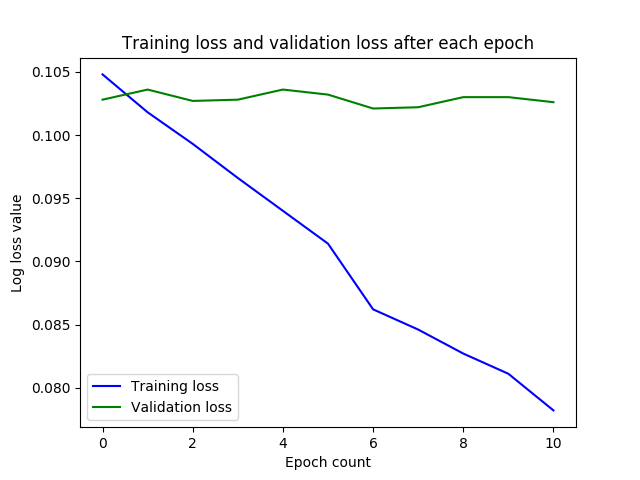

In [0]:
# CNN convergence plot
from IPython.display import Image
cnn_plot = os.path.join(DATA_DIR, 'cnn_convergence_plot.png')
Image(cnn_plot)

In [0]:
from keras.models import load_model
cnn = load_model(CNN_BEST_MODEL, 
                 custom_objects={'precision_metric': precision_metric,
                                 'recall_metric': recall_metric,
                                 'f1_metric': f1_metric})
test_preds = cnn.predict(test_feats)

/usr/local/lib/python3.6/dist-packages/keras/engine/topology.py:1269: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
# Obtain DNN test set predictions precision, recall and F1-score
test_preds = [1 if x >= 0.5 else 0 for x in test_preds]
prec = precision_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
f1_score = (2*prec*recall) / (prec+recall)
print ("Precision of predictions from text CNN ", prec)
print ("Recall of predictions from text CNN ", recall)
print ("f1_score of predictions from text CNN ", f1_score)

Precision of predictions from text CNN  0.6899595830674324
Recall of predictions from text CNN  0.53838492820981
f1_score of predictions from text CNN  0.604820288098457


#### **3. Results and  Conclusion**

We have splitted the data into train and test set (70 - 30)% split and have used gridsearch CV for hyperparameter tuning and for neural net based models we have created a seperate validation set, the plots for the same are generated in the respective sections. The results on the test set for each model are consolidated below:


Model | Precision | Recall | f1 score
--- | --- | --- | --- 
Logistic Regression (Ridge) | 37.42 | 86.12 | 52.17
Logistic Regression (Lasso) | 37 | 87 | 52
Decision Trees | 55 | 39 | 46
Random Forest | 73 | 6 | 11
Single Layer NN | 66.95 | 55.53 | 60.71
CNN | 68.99 | 53.83 | 60.48 |



From above table we can conclude that neural net based models have performed better, with Single Layer NN giving the best metric values for Precision, recall and f1-score. We also observed that, performance of tree based models is not good for this data. Neural Networks and CNNs give much better results in terms of both precision and recall which can be attributed to their ability to model input features to very high dimensional feature space, and in turn learn feature representation that maximises performance on the given data-set



#### **4. Future Plans**
We plan to implement Recurrent Neural Networks to detect insincere questions with better F1 score[3].

#### **5. References**
[1] Quora Insincere questions classification: https://www.kaggle.com/c/quora-insincere-questions-classificati

[2] Kim, Yoon. ”Convolutional neural networks for sentence classification.” arXiv preprint arXiv:1408.5882 (2014).

[3] The Unreasonable Effectiveness of Recurrent Neural Net- works – Blog by Andrej Karpathy http://karpathy.github.io/2015/05/21/rnn-effectiveness/